In [22]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [23]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [24]:
tiny_ceo_df = ceo_df[ceo_df['SIZE_CATEGORY'] == 'Tiny']
medium_ceo_df = ceo_df[ceo_df['SIZE_CATEGORY'] == 'Medium']
big_ceo_df = ceo_df[ceo_df['SIZE_CATEGORY'] == 'Big']
huge_ceo_df = ceo_df[ceo_df['SIZE_CATEGORY'] == 'Huge']

tiny_bod_df = bod_df[bod_df['SIZE_CATEGORY'] == 'Tiny']
medium_bod_df = bod_df[bod_df['SIZE_CATEGORY'] == 'Medium']
big_bod_df = bod_df[bod_df['SIZE_CATEGORY'] == 'Big']
huge_bod_df = bod_df[bod_df['SIZE_CATEGORY'] == 'Huge']



list_ceo_df = [tiny_ceo_df, medium_ceo_df, big_ceo_df, huge_ceo_df]
list_bod_df = [tiny_bod_df, medium_bod_df, big_bod_df, huge_bod_df]

In [26]:
df = huge_ceo_df
df = df.drop(['Unnamed: 0'], axis=1)
df = df.replace(0, np.nan)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['YEAR'] >= 2010) & (df['YEAR'] <= 2016)]
holdout_mask = df.loc[(df['YEAR'] >= 2017) & (df['YEAR'] <= 2019)]

y = np.log(train_mask.TDC1)
X = train_mask.drop('TDC1', axis=1)

VarY = holdout_mask[['signature_index', 'TDC1']].to_csv('Saved/tiny_ceo_df.csv', index=False)
holdout_X = holdout_mask.drop('TDC1', axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

cv = KFold(10)

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [7]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['GENDER']),
    remainder="drop",
)

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [8]:
alphas = list(np.linspace(100, 300, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

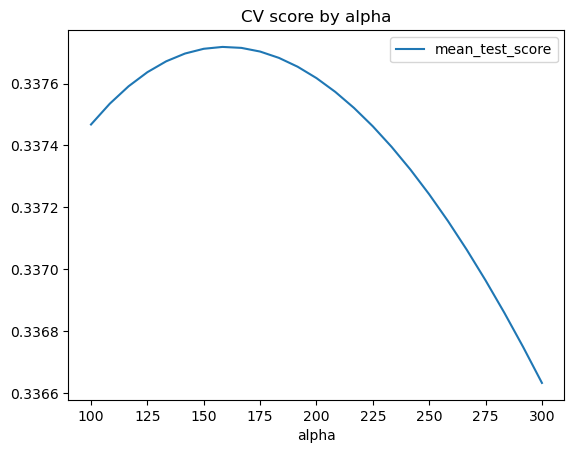

In [9]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

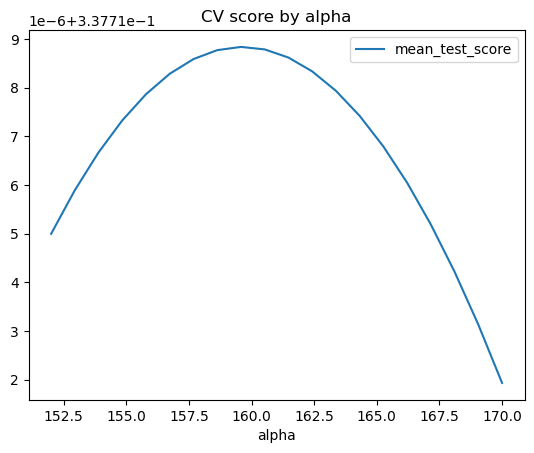

In [11]:
alphas = list(np.linspace(152, 170,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [14]:
##### 0.00184
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 159.57895


In [15]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: 0.33772


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GVKEY            0 non-null      int64  
 1   TICKER           0 non-null      object 
 2   CEOANN           0 non-null      object 
 3   SALARY           0 non-null      float64
 4   BONUS            0 non-null      float64
 5   STOCK_AWARDS     0 non-null      float64
 6   OPTION_AWARDS    0 non-null      float64
 7   OTHCOMP          0 non-null      float64
 8   TOTAL_CURR       0 non-null      float64
 9   AGE              0 non-null      float64
 10  TDC1             0 non-null      float64
 11  YEAR             0 non-null      int64  
 12  BECAMECEO        0 non-null      object 
 13  JOINED_CO        0 non-null      object 
 14  LEFTOFC          0 non-null      object 
 15  GENDER           0 non-null      object 
 16  CUSIP            0 non-null      object 
 17  NAICSDESC        0 non-null 